# Time-resolved fitting with RL

Run 189245: 0.6V to 0.1V

In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


## Set up the environment

In [11]:
import rl_model
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(git_dir, 'data', '189228-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189237-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189236-time-resolved.json')

with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = False
MIXING = True

# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE, allow_mixing=MIXING)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()

Number of times: 25
0


## View the initial time and check that the initial model makes sense

Time: 0
reward: -14.762466851785423
[ 0.09542739  0.45447298 -0.6012057   0.        ]


<IPython.core.display.Javascript object>


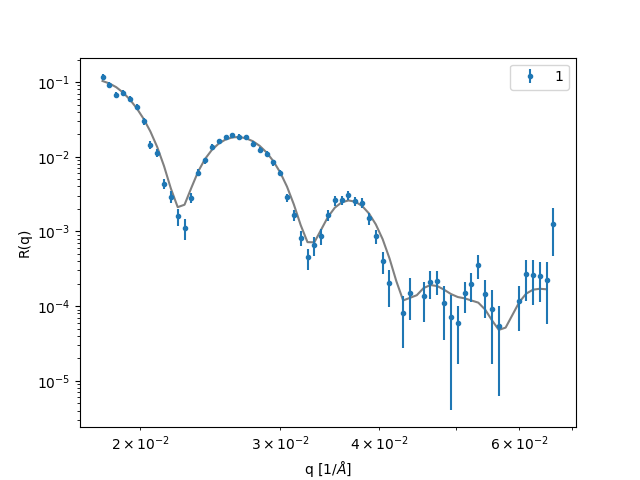

In [12]:
terminated = False
print("Time:", timestamps[env.time_stamp])

# choose a random action
if False:
    action = env.action_space.sample() 
else:
    action = env.normalized_parameters

if MIXING:
    action = list(action)
    action.append(0)
    action = np.asarray(action)

# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
# show the current position and reward
env.render(action=action, reward=reward) 
env.plot(errors=True)



## Train or load model

In [13]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-01-to-06-mixing-fwd/",
    name_prefix="rl_model",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if False:
    model.learn(20000, callback=checkpoint_callback)
    model.save('UIUC-01-to-06-SAC-mixing-fwd')
else:
    #model = SAC.load('UIUC-01-to-06-SAC-backward')
    #model = SAC.load('UIUC-01-to-06-SAC-mixing')
    model = SAC.load('UIUC-01-to-06-SAC-mixing-fwd')

CPU times: user 25 ms, sys: 14.3 ms, total: 39.3 ms
Wall time: 35.7 ms


## Compute uncertainties

In [5]:
deltas = env.high_array - env.low_array

samples = []
mixing = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)

    if MIXING:
        mixing.append((1+actions[:,-1]) / 2.0)


samples = np.asarray(samples).T
mixing = np.asarray(mixing).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)


mixing_err = np.std(mixing, axis=1)
print(mixing_err.shape)

(3, 25, 100)
(3, 25)
(25,)


## Run the agent on the time series data

In [6]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    chi2.append(env.chi2)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 25
Time 0 [0.]: -48.2287 [False] -48.2287
Time 60 [0.04166667]: -2.36035 [False] -50.589
Time 120 [0.08333334]: -2.60116 [False] -53.1902
Time 180 [0.125]: -3.07775 [False] -56.2679
Time 240 [0.16666667]: -1.51261 [False] -57.7805
Time 300 [0.20833333]: -3.38022 [False] -61.1608
Time 360 [0.25]: -3.57447 [False] -64.7352
Time 420 [0.29166666]: -3.85819 [False] -68.5934
Time 480 [0.33333334]: -5.49597 [False] -74.0894
Time 540 [0.375]: -8.62083 [False] -82.7102
Time 600 [0.41666666]: -6.03572 [False] -88.7459
Time 660 [0.45833334]: -8.86655 [False] -97.6125
Time 720 [0.5]: -11.2289 [False] -108.841
Time 780 [0.5416667]: -11.622 [False] -120.463
Time 840 [0.5833333]: -12.0129 [False] -132.476
Time 900 [0.625]: -14.6174 [False] -147.094
Time 960 [0.6666667]: -15.3271 [False] -162.421
Time 1020 [0.7083333]: -15.5974 [False] -178.018
Time 1080 [0.75]: -16.6093 [False] -194.627
Time 1140 [0.7916667]: -22.6252 [False] -217.253
Time 1200 [0.8333333]: -17.6586 [False] -234.911


## Plot the results and compare to the Bayesian approach

<IPython.core.display.Javascript object>


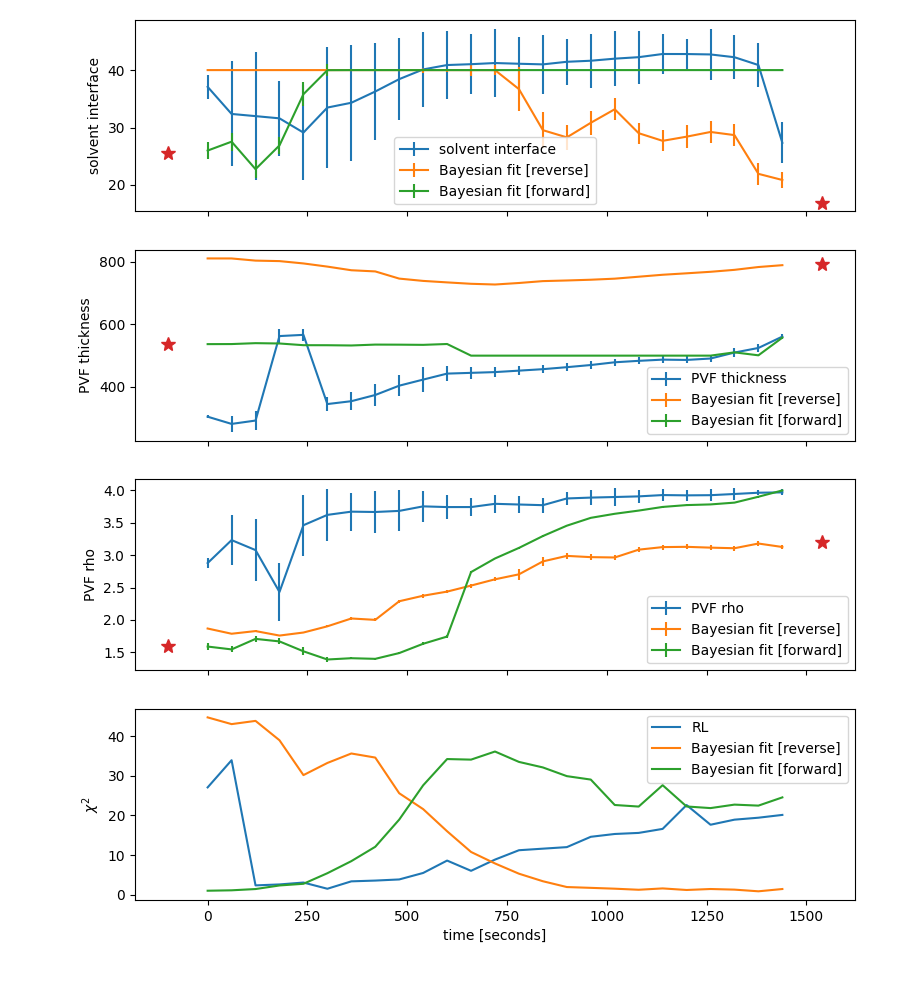

['solvent interface', 'PVF thickness', 'PVF rho']
[   0   60  120  180  240  300  360  420  480  540  600  660  720  780
  840  900  960 1020 1080 1140 1200 1260 1320 1380 1440]


Text(0.5, 0, 'time [seconds]')

In [7]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189236-bayes-forward.json')) as fd:
    bayes_fits_fwd = json.load(fd)
with open(os.path.join(git_dir, 'data', '189236-bayes-backward.json')) as fd:
    bayes_fits = json.load(fd)

t_delay = 100
if REVERSE:
    t_start = times[0]+t_delay
    t_end = -t_delay
else:
    t_end = times[-1]+t_delay
    t_start = -t_delay

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [reverse]')

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [forward]')
    
    plt.plot([t_start, t_end], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(times, chi2, label = 'RL')
print(timestamps)
plt.plot(timestamps, bayes_fits['chi2'], label = 'Bayesian fit [reverse]')
plt.plot(timestamps, bayes_fits_fwd['chi2'], label = 'Bayesian fit [forward]')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

<IPython.core.display.Javascript object>


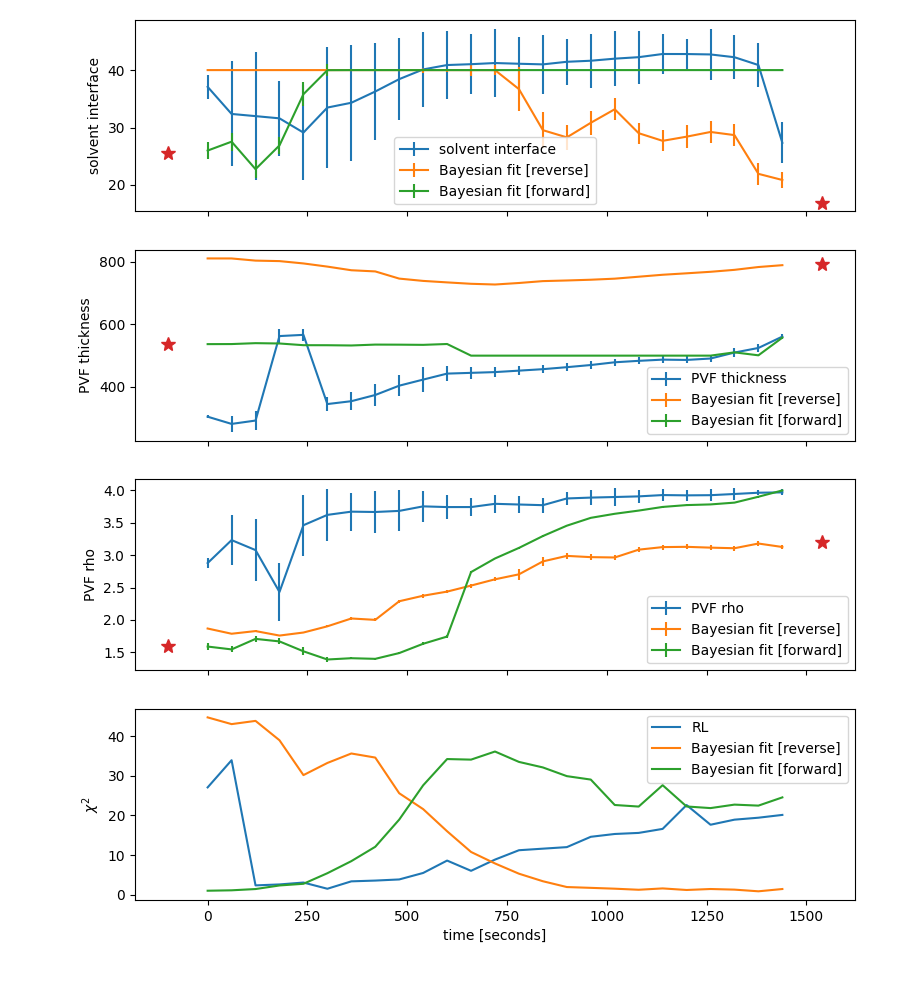

['solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'time [seconds]')

In [8]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189236-bayes-forward.json')) as fd:
    bayes_fits_fwd = json.load(fd)
with open(os.path.join(git_dir, 'data', '189236-bayes-backward.json')) as fd:
    bayes_fits = json.load(fd)


t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    fwd_times = np.flip(times)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    fwd_times = times

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [reverse]')

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [forward]')

    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(times, chi2, label = 'RL')
plt.plot(fwd_times, bayes_fits['chi2'], label = 'Bayesian fit [reverse]')
plt.plot(fwd_times, bayes_fits_fwd['chi2'], label = 'Bayesian fit [forward]')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

<IPython.core.display.Javascript object>


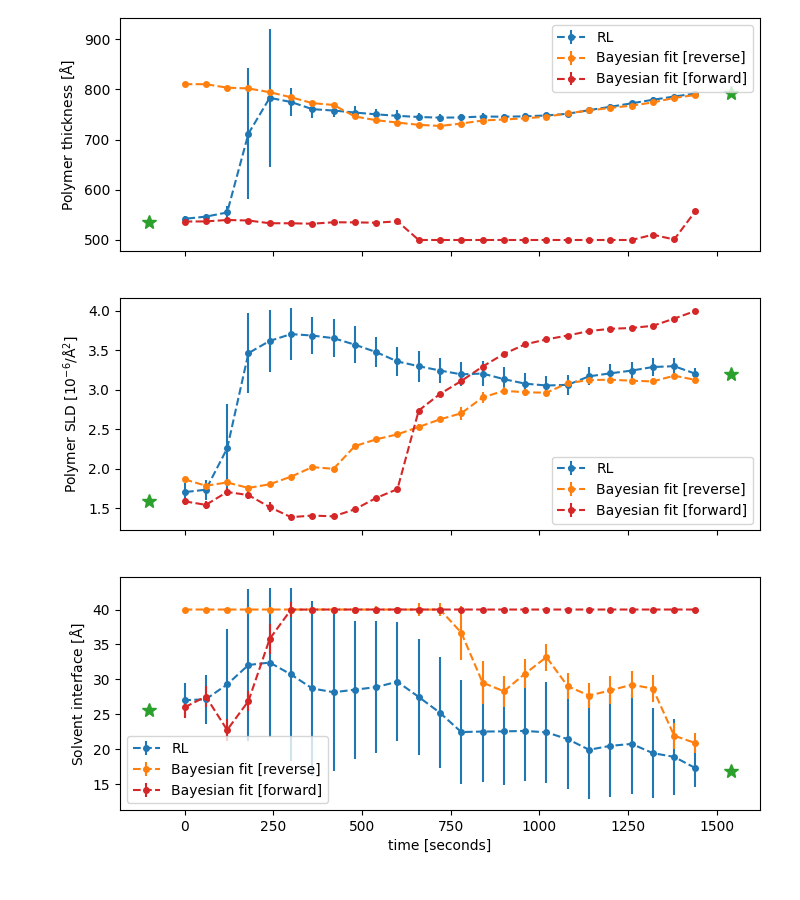

['solvent interface', 'PVF thickness', 'PVF rho']


Text(0.5, 0, 'time [seconds]')

In [63]:

fig, axs = plt.subplots(3,1, dpi=100, figsize=(8,9), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)

axes = ['Solvent interface [$\mathrm{\AA}$]',
        'Polymer thickness [$\mathrm{\AA}$]',
        'Polymer SLD [$10^{-6}/\mathrm{\AA}^2$]']

position = 0
for i in [1,2,0]:
    position += 1
    ax = plt.subplot(3, 1, position)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label='RL', marker='.', markersize=8, linestyle='--')

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [reverse]', marker='.', markersize=8, linestyle='--')
    
    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(fwd_times, values, yerr=d_values, label='Bayesian fit [forward]', marker='.', markersize=8, linestyle='--')
 
    plt.ylabel(axes[i])
    plt.legend()

plt.xlabel("time [seconds]")

Number of times: 25


<IPython.core.display.Javascript object>


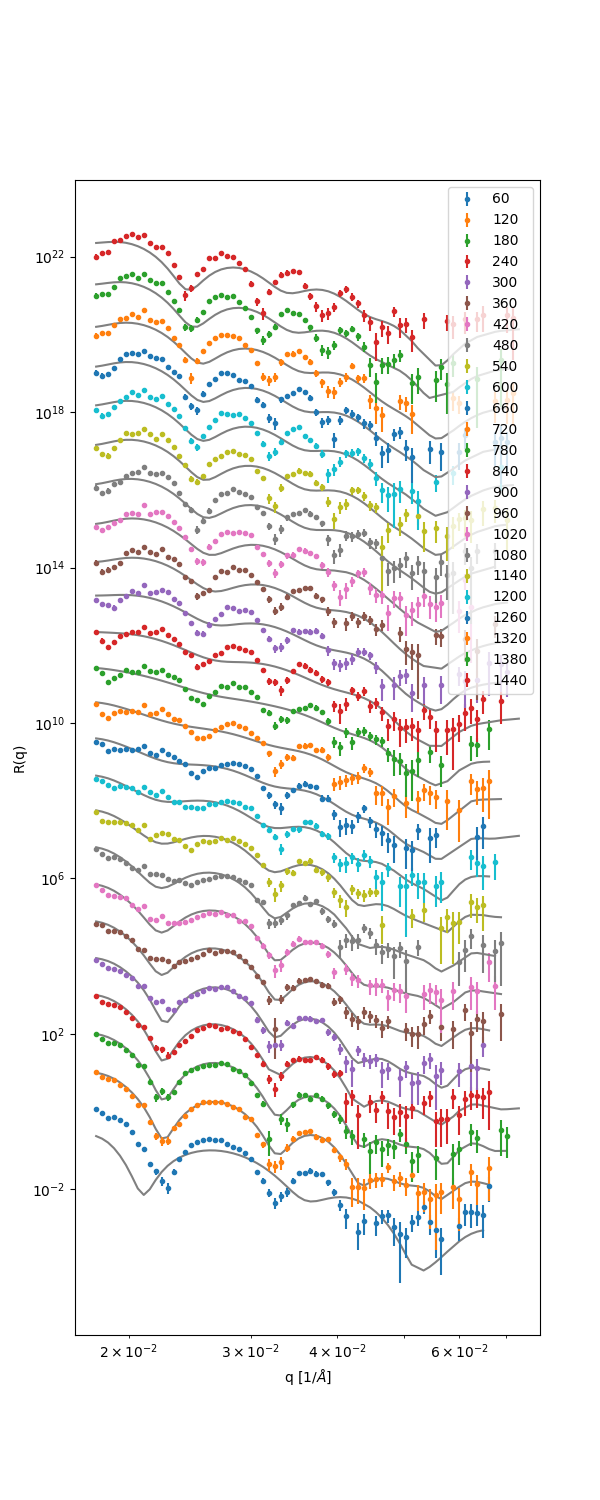

In [9]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False, errors=True, label=times[i])


<IPython.core.display.Javascript object>


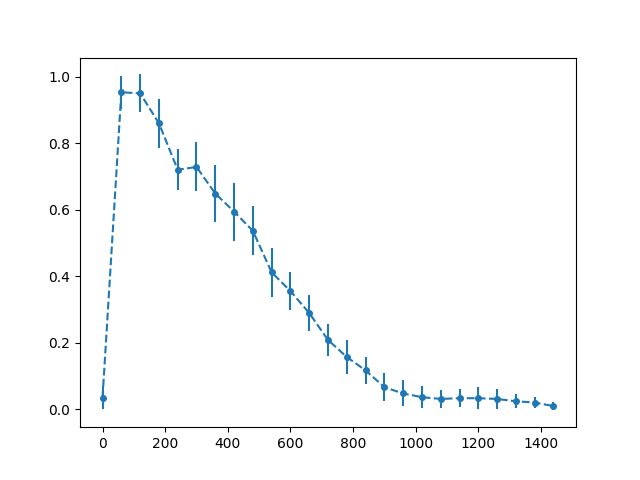

<ErrorbarContainer object of 3 artists>

In [10]:
actions = np.asarray(actions)
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0


mixing = (actions[:,-1] + 1)/2.0


fig = plt.subplots(dpi=100, )

plt.errorbar(times, mixing, yerr=mixing_err, label='Bayesian fit [forward]', marker='.', markersize=8, linestyle='--')
 
